In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
%pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isaackimani","key":"1746902c1891891e835edc7aa052ddeb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [5]:
train_dir = "training_set/training_set"
test_dir = "test_set/test_set"

In [6]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transforms)
full_test_dataset = datasets.ImageFolder(root=test_dir, transform=transforms)

In [8]:
len(full_train_dataset), len(full_test_dataset)

(8005, 2023)

In [9]:
# create dictionaries to hold the indices for each class
train_indices_per_class = {cls: [] for cls in full_train_dataset.class_to_idx.values()}
test_indices_per_class = {cls: [] for cls in full_test_dataset.class_to_idx.values()}

# populate the index directories for the training set
for i, (_, class_index) in enumerate(full_train_dataset.imgs):
  if len(train_indices_per_class[class_index]) < 500:
    train_indices_per_class[class_index].append(i)

# populate the index dictionaries for testing set
for i, (_, class_index) in enumerate(full_test_dataset.imgs):
  if len(test_indices_per_class[class_index]) < 500:
    test_indices_per_class[class_index].append(i)

# combine the list of indices for the subsets
train_subset_indices = sum(train_indices_per_class.values(), [])
test_subset_indices = sum(test_indices_per_class.values(), [])

In [10]:
# create the subset datasets
train_subset = Subset(full_train_dataset, train_subset_indices)
test_subset = Subset(full_test_dataset, test_subset_indices)

print(f"no. of images in training subset: {len(train_subset)}")
print(f"no. of images in testing subset: {len(test_subset)}")

no. of images in training subset: 1000
no. of images in testing subset: 1000


In [11]:
# create dataloaders for the subsets
batch_size = 32
train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

image path: training_set/training_set/cats/cat.3239.jpg
images class: cats
image height: 374
image width: 500


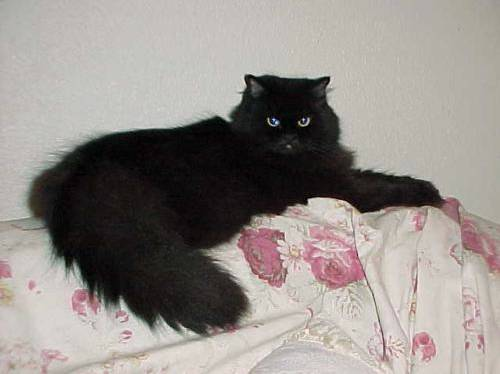

In [12]:
#visualizing an image
import random
from PIL import Image
from pathlib import Path

# get all the image paths
image_path_list = list(Path(train_dir).glob("*/*.jpg"))

# pick a random image path
random_image_path = random.choice(image_path_list)

# get the image class from the path name
image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print(f"image path: {random_image_path}")
print(f"images class: {image_class}")
print(f"image height: {img.height}")
print((f"image width: {img.width}"))
img

In [13]:
def get_model():
  model= models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
  model.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid(),
      )
  return model

In [14]:
model = get_model()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 82.2MB/s]


In [15]:
%pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

create train and test loops

In [20]:
# create train_step()
def train_step(model, dataloader, loss_fn, optimizer):
  #put the model in train mode
  model.train()

  #setup train loss and train acc values
  train_loss, train_acc = 0, 0

  # loop thur the dataloader data batches
  for batch, (x, y) in enumerate(dataloader):
    # move data to target device
    x, y = x.to(model.parameters().__next__().device), y.to(model.parameters().__next__().device)

    # do a forward pass
    y_pred = model(x)
    # calculate the loss
    # BCELoss expects target to be float and same shape as input
    loss = loss_fn(y_pred, y.float().unsqueeze(1))
    train_loss += loss.item()
    # optimizer zero_grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()

    # calculate accuracy metric
    y_pred_class = torch.round(y_pred) # round the output probability to 0 or 1
    train_acc += (y_pred_class.squeeze() == y).sum().item()/len(y_pred)

  # adjust metrics to get loss and acc per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [21]:
# create the testing function
def test_step(model, dataloader, loss_fn):
  # put model in eval mode
  model.eval()
  # setup test loss and test acc
  test_loss, test_acc = 0, 0
  #turn on inference mode
  with torch.inference_mode():
    # loop through the dataloaderbatches
    for batch, (x, y) in enumerate(dataloader):
      # move data to target device
      x, y = x.to(model.parameters().__next__().device), y.to(model.parameters().__next__().device)

      # forward pass
      test_pred_logits = model(x)
      #calculate the loss
      # BCELoss expects target to be float and same shape as input
      loss = loss_fn(test_pred_logits, y.float().unsqueeze(1))
      test_loss += loss.item()
      # calculate the acc
      test_pred_labels = torch.round(test_pred_logits) # round the output probability to 0 or 1
      test_acc += ((test_pred_labels.squeeze() == y).sum().item()/len(test_pred_labels))

  # get avg loss and acc per batch
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc

train function to combine train and test loops

In [30]:
from tqdm.auto import tqdm

# create train function
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=5):
  # create an empty results dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # loop thru training and test sep for a number of epochs
  for epoch in tqdm(range(5)):
    train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    # print info
    print(f"epoch: {epoch} | train loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss} | test_acc: {test_acc}")

    # update results dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [31]:
model_results = train(model=model,
                      train_dataloader=train_dl,
                      test_dataloader=test_dl,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0 | train loss: 0.010799579016747884 | train_acc: 0.9990234375 | test_loss: 0.04798614211540553 | test_acc: 0.986328125
epoch: 1 | train loss: 0.013952208257251186 | train_acc: 0.9990234375 | test_loss: 0.05033691181233735 | test_acc: 0.9853515625
epoch: 2 | train loss: 0.01261525806694408 | train_acc: 0.9970703125 | test_loss: 0.13157095009592013 | test_acc: 0.986328125
epoch: 3 | train loss: 0.008825759849059978 | train_acc: 0.9990234375 | test_loss: 0.13260544990407652 | test_acc: 0.984375
epoch: 4 | train loss: 0.008512283664458664 | train_acc: 0.9990234375 | test_loss: 0.13082195499555382 | test_acc: 0.9853515625


In [32]:
def plot_loss_curves(results):
  """plots trainng curve of a results dict"""
  # get the loss values of the results dict
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the acc values  of the results dict (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15, 7))

  # plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot the acc
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

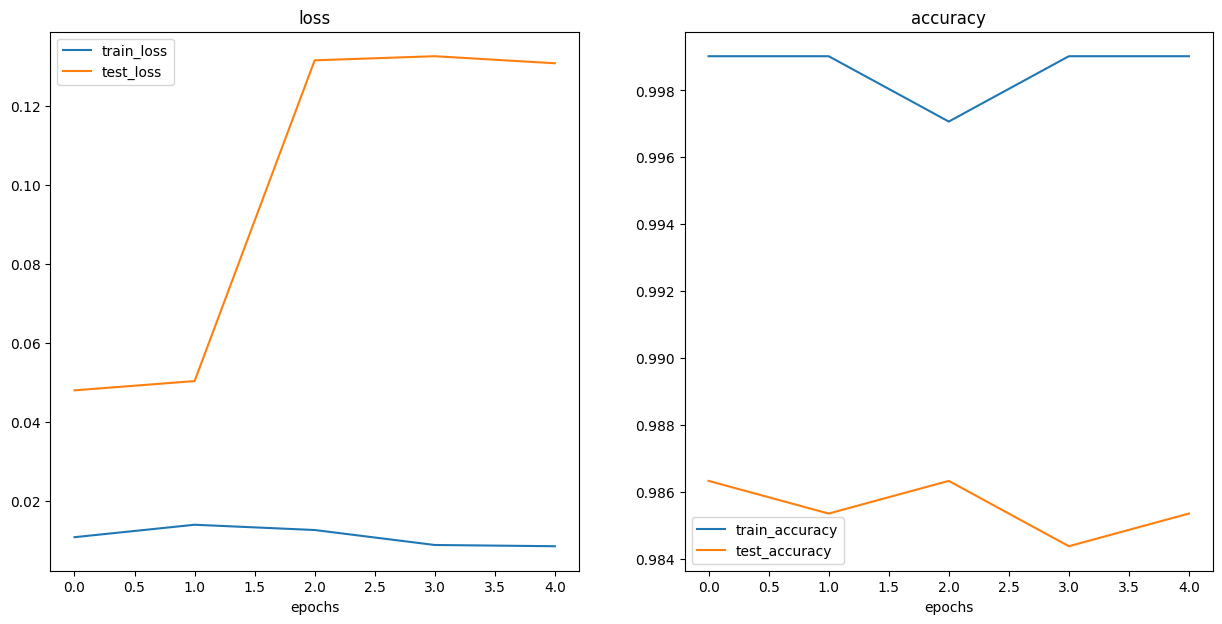

In [33]:
plot_loss_curves(model_results)

In [34]:
model2 = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


In [35]:
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

freeze all base layers and change the output layer to fit out problem

In [37]:
# freeze all base layers in model2
for param in model2.parameters():
  param.requires_grad = False

In [40]:
# update the linear layer
model2.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model2.fc= nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

In [41]:
summary(model2, torch.zeros(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [43]:
model2_results = train(model=model2,
      train_dataloader=train_dl,
      test_dataloader=test_dl,
      optimizer=optimizer,
      loss_fn=loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0 | train loss: 0.6888624578714371 | train_acc: 0.53515625 | test_loss: 0.6839792467653751 | test_acc: 0.5595703125
epoch: 1 | train loss: 0.6884054634720087 | train_acc: 0.53125 | test_loss: 0.6823267098516226 | test_acc: 0.5751953125
epoch: 2 | train loss: 0.6925666034221649 | train_acc: 0.5078125 | test_loss: 0.6831817720085382 | test_acc: 0.5625
epoch: 3 | train loss: 0.6874916199594736 | train_acc: 0.544921875 | test_loss: 0.6841617412865162 | test_acc: 0.5625
epoch: 4 | train loss: 0.6899365950375795 | train_acc: 0.5390625 | test_loss: 0.6838254053145647 | test_acc: 0.5546875


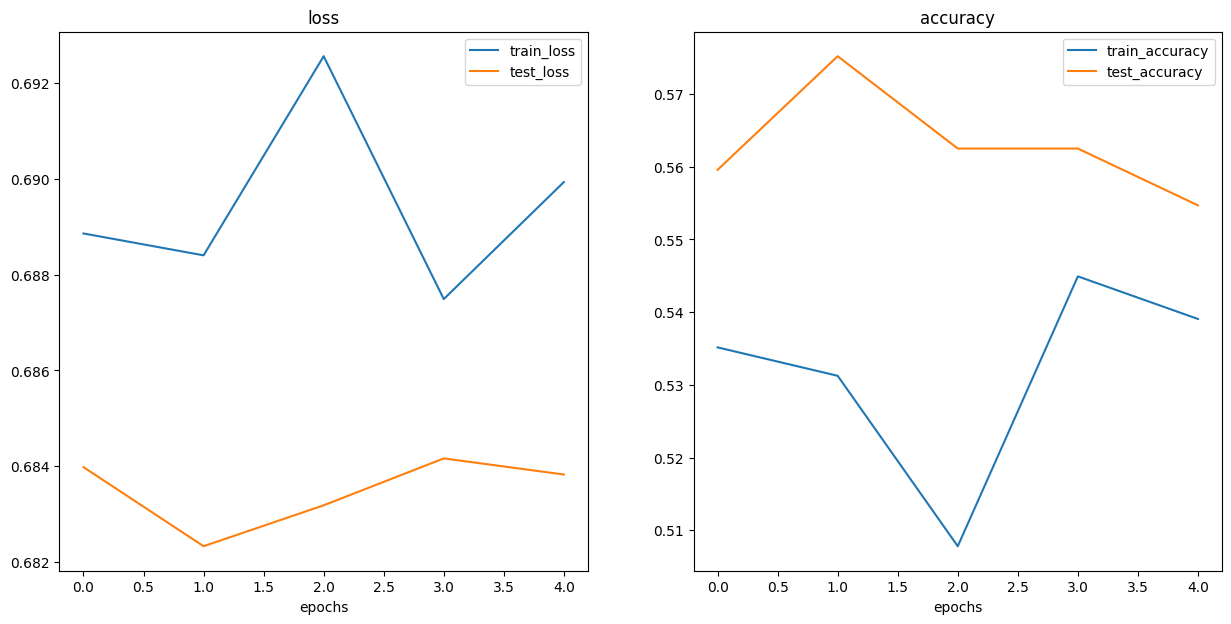

In [44]:
plot_loss_curves(model2_results)